Epoch 0, Loss: 1.195271372795105
Epoch 10, Loss: 0.7761273980140686
Epoch 20, Loss: 0.6055291891098022
Epoch 30, Loss: 0.49297112226486206
Epoch 40, Loss: 0.4139401614665985
Epoch 50, Loss: 0.3561117351055145
Epoch 60, Loss: 0.3124835789203644
Epoch 70, Loss: 0.2780810296535492
Epoch 80, Loss: 0.25072214007377625
Epoch 90, Loss: 0.22722949087619781
Epoch 100, Loss: 0.20850276947021484
Epoch 110, Loss: 0.1928725242614746
Epoch 120, Loss: 0.1811354160308838
Epoch 130, Loss: 0.1700018048286438
Epoch 140, Loss: 0.1614060401916504
Epoch 150, Loss: 0.15297049283981323
Epoch 160, Loss: 0.14562176167964935
Epoch 170, Loss: 0.13897943496704102
Epoch 180, Loss: 0.13538196682929993
Epoch 190, Loss: 0.12983493506908417


C:\Users\d.mentock\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


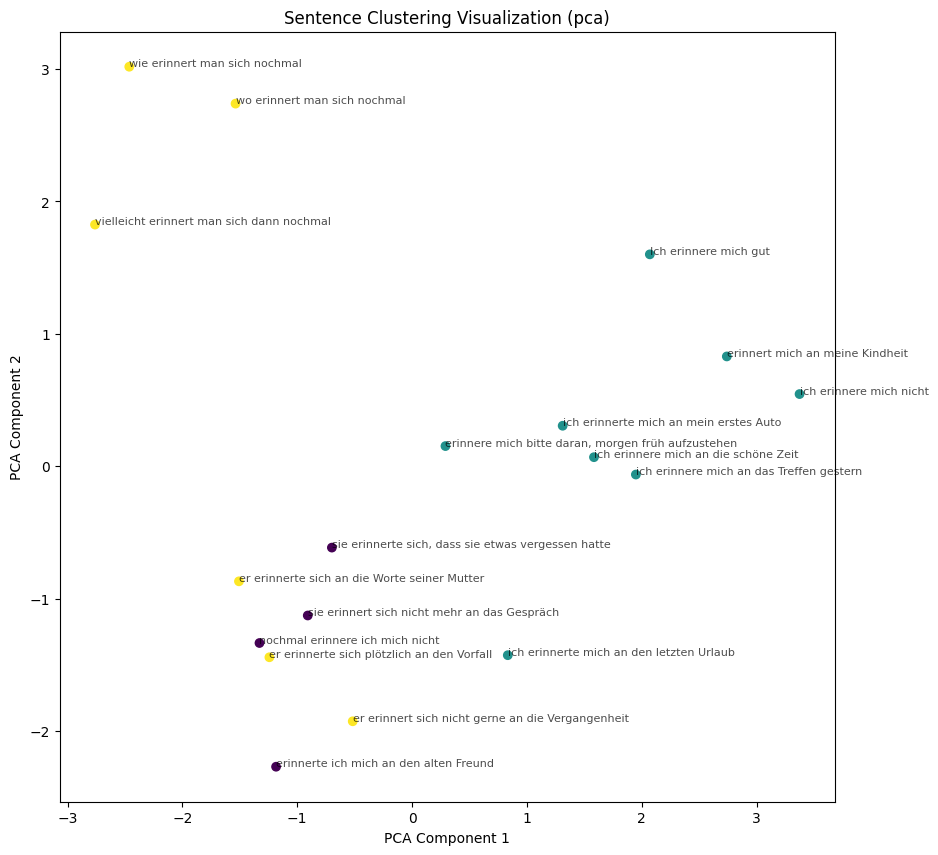

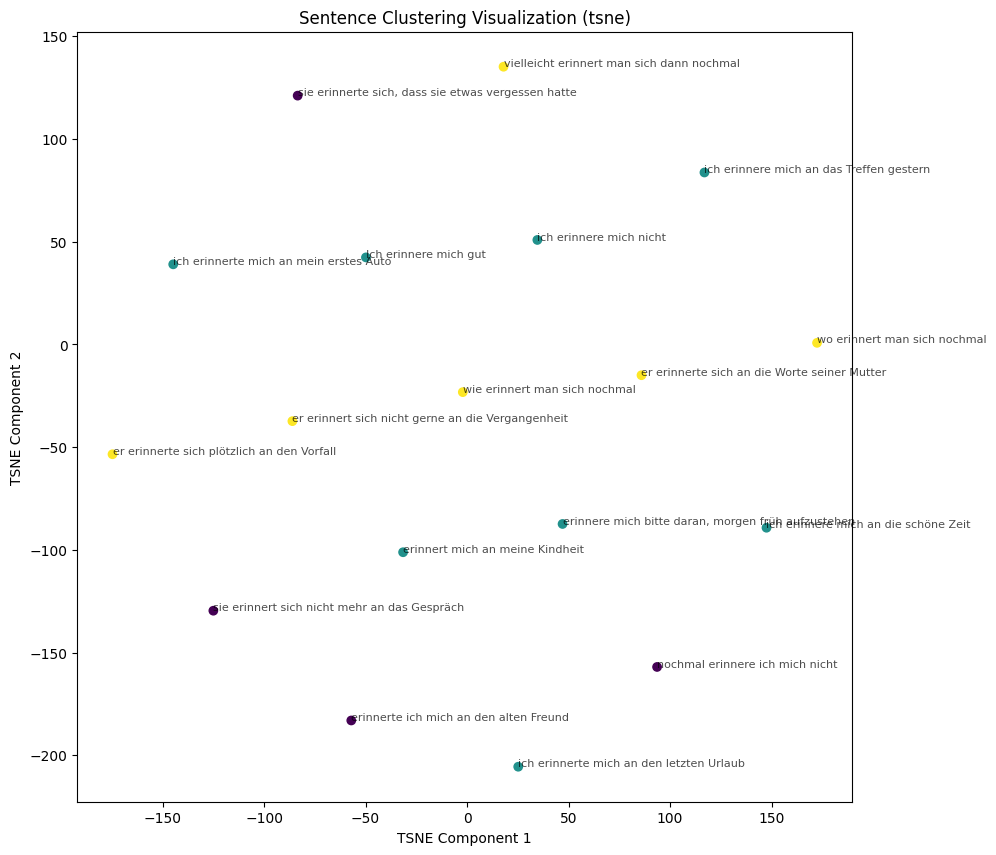

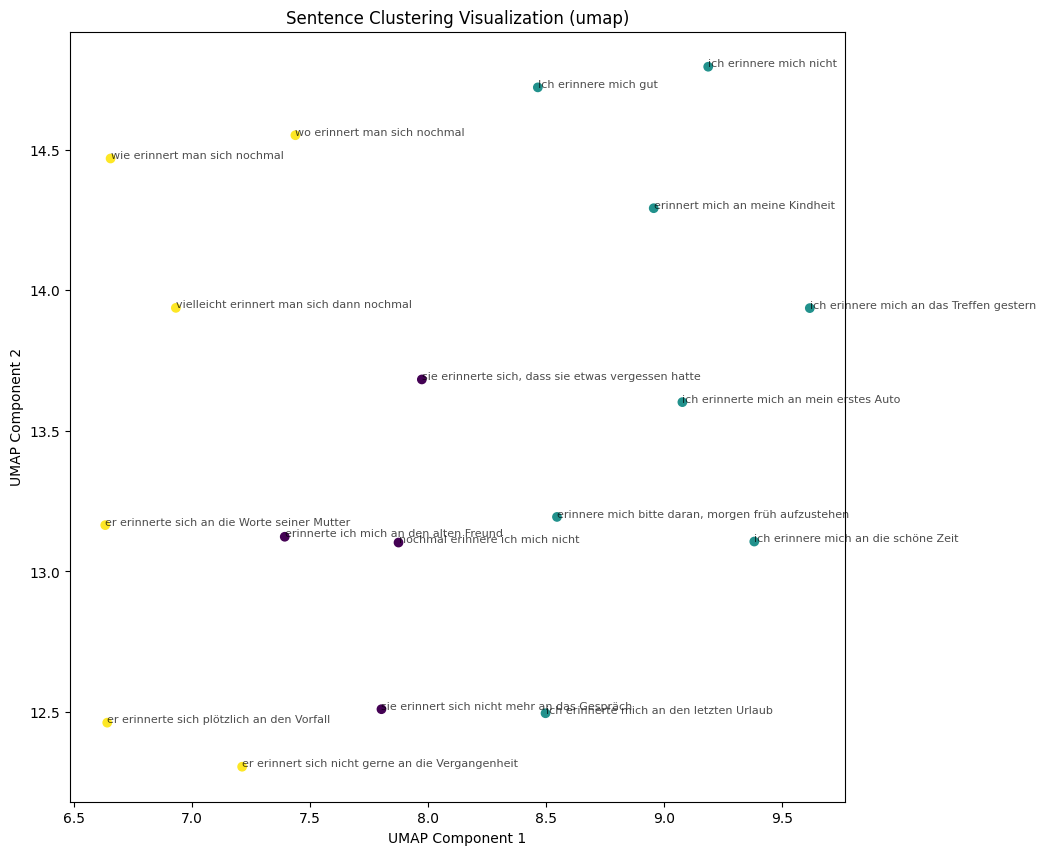

C:\Users\d.mentock\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


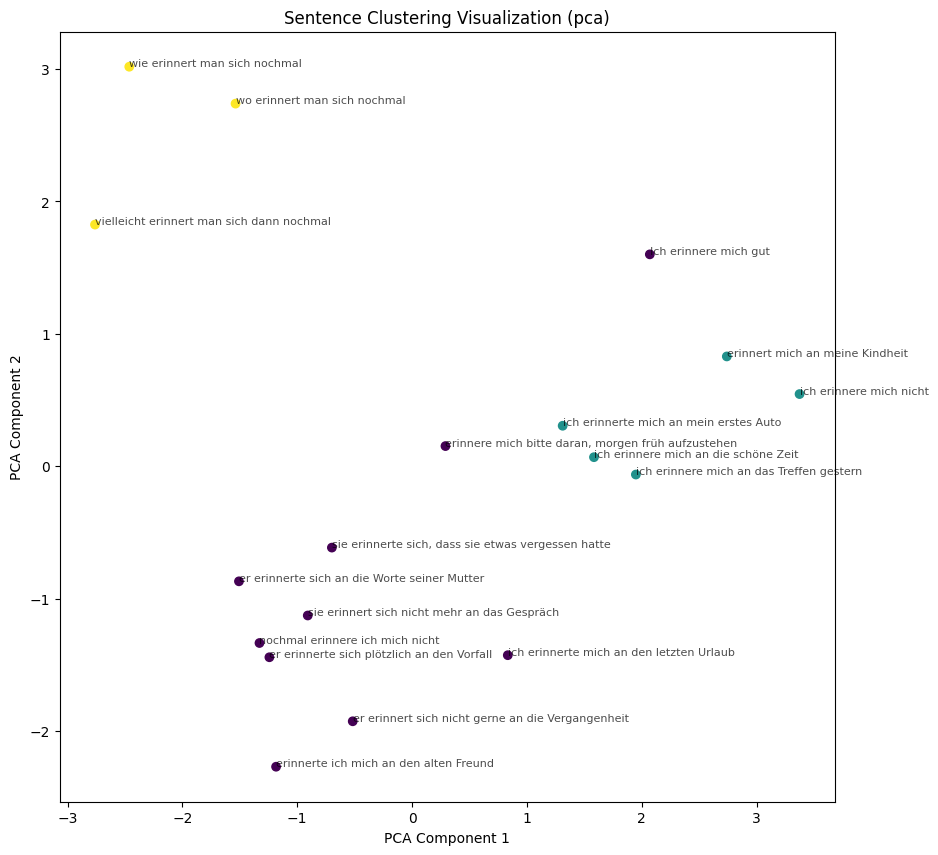

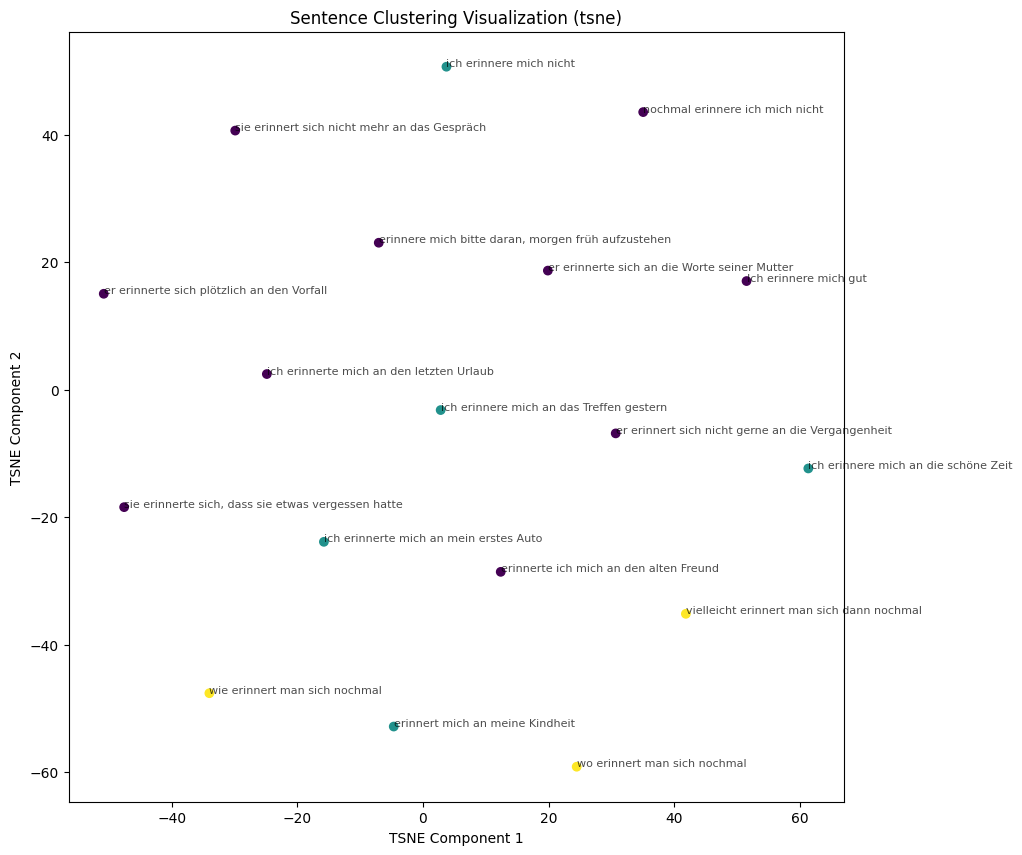

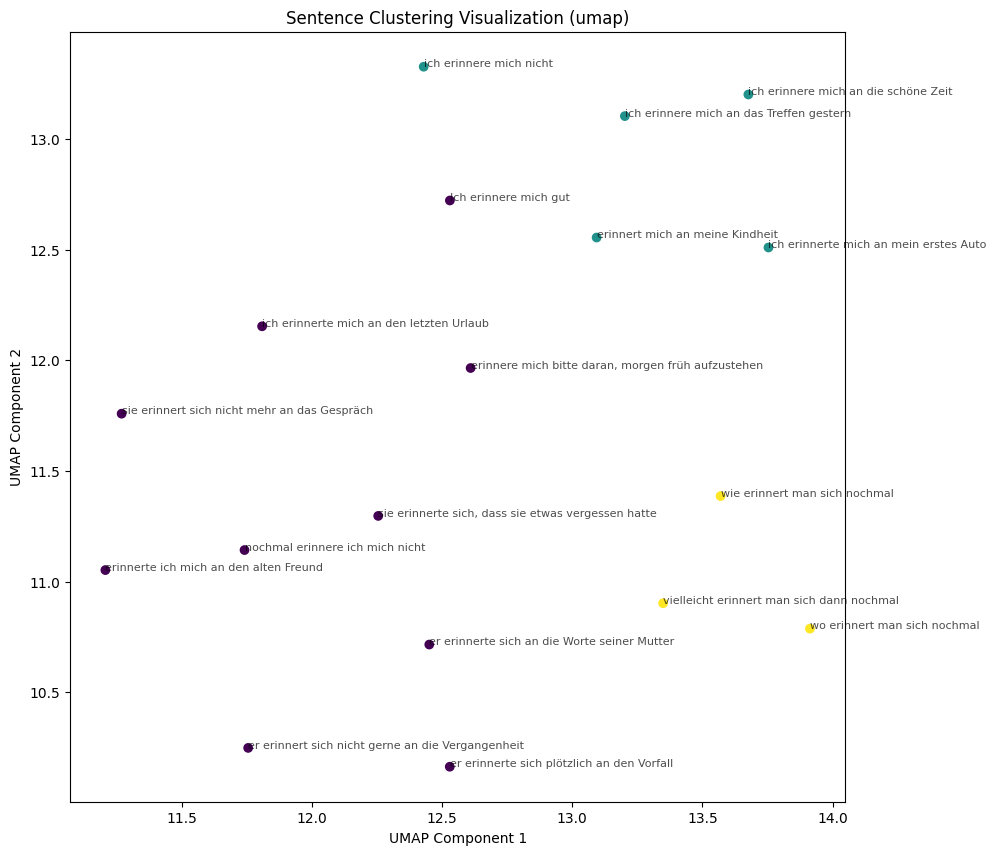

C:\Users\d.mentock\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


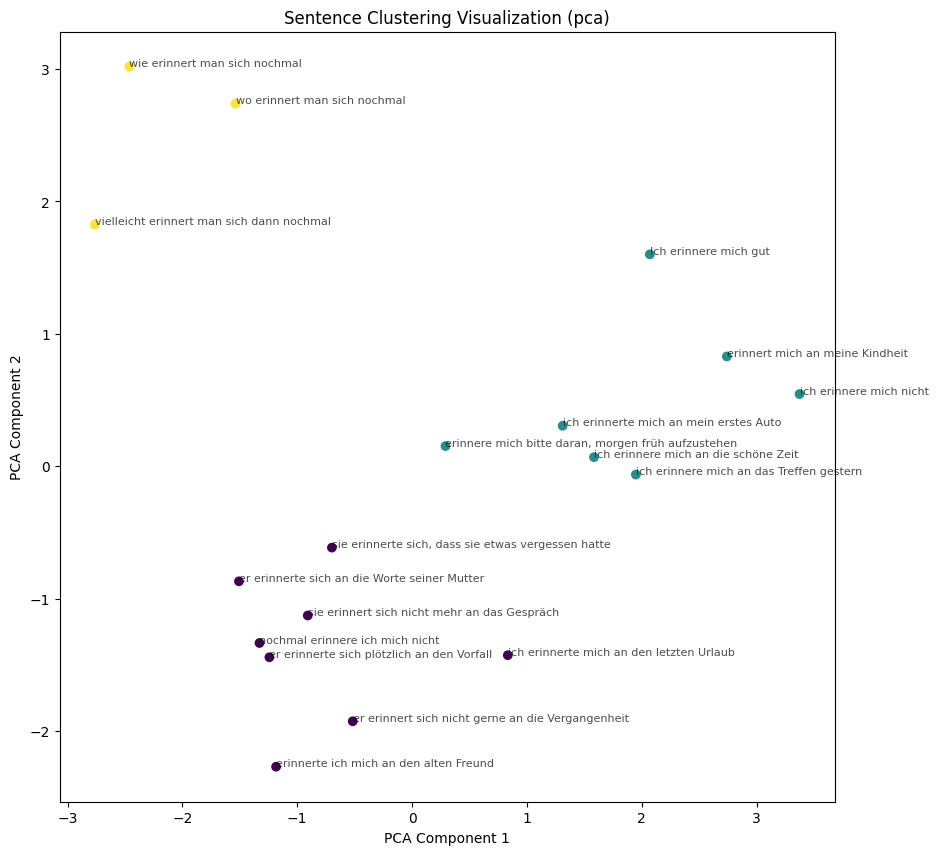

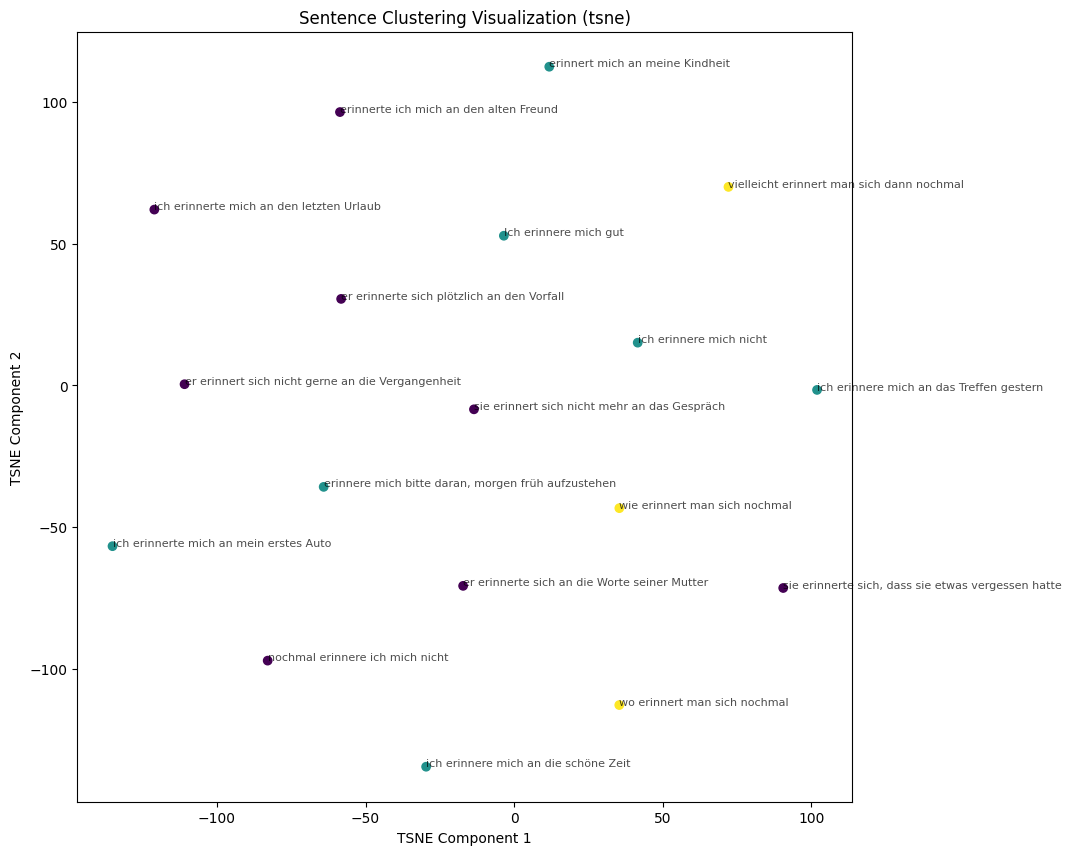

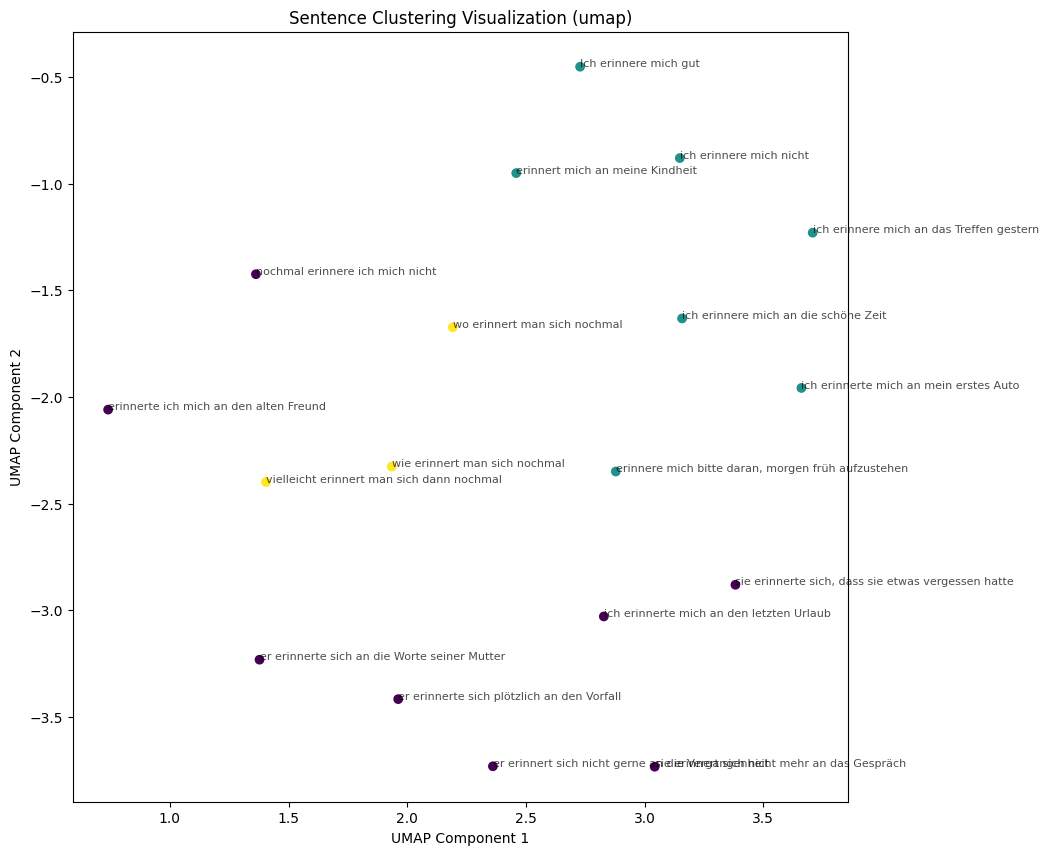

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import umap

import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, deque

import torch
import torch.nn as nn


class Attention(nn.Module):
    def __init__(self, input_dim):
        super(Attention, self).__init__()
        self.attention_weights = nn.Linear(input_dim, 1, bias=False)

    def forward(self, word_vectors):
        """
        Applies attention to word vectors and returns a weighted sum.
        word_vectors: Tensor of shape (num_words, embedding_dim)
        """
        scores = self.attention_weights(word_vectors)  # Compute attention scores
        weights = torch.softmax(scores, dim=0)  # Normalize scores to get weights
        weighted_sum = torch.sum(weights * word_vectors, dim=0)  # Weighted sum of word vectors
        return weighted_sum, weights


class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Second GCN layer
        x = self.conv2(x, edge_index)
        return x

class Node:
    def __init__(self, word, id):
        self.word = word
        self.id = id
        self.count = 0
        self.children = {}

class PatternExtractorWithGNN:
    def __init__(self):
        self.preceding_tree = Node('<ROOT>', 0)
        self.following_tree = Node('<ROOT>', 1)
        self.node_counter = 2
        self.word_to_ids = defaultdict(list)
        self.id_to_node = {0: self.preceding_tree, 1: self.following_tree}
        self.child_to_parents = defaultdict(list)
        self.graph = nx.DiGraph()  # Graph to store word relations
        self.node_embeddings = {}  # To store GCN embeddings
        self.attention = Attention(100)  # Assuming 100 is the embedding size

    def add_start_end_flags_lower(self, sentences):
        return [f"<START> {sentence.lower()} <END>" for sentence in sentences]

    def get_or_create_node(self, current_tree, word, parent_id=None):
        if word not in current_tree.children:
            new_node = Node(word, self.node_counter)
            current_tree.children[word] = new_node
            self.word_to_ids[word].append(self.node_counter)
            self.id_to_node[self.node_counter] = new_node
            if parent_id is not None:
                self.child_to_parents[self.node_counter].append(parent_id)
                self.graph.add_edge(parent_id, self.node_counter)  # Add edge in the graph
            self.node_counter += 1
        else:
            child_id = current_tree.children[word].id
            if parent_id is not None:
                self.child_to_parents[child_id].append(parent_id)
                self.graph.add_edge(parent_id, child_id)
        return current_tree.children[word]

    def add_to_tree(self, words, direction):
        current_tree = self.preceding_tree if direction == 'preceding' else self.following_tree
        word_range = range(len(words) - 1, -1, -1) if direction == 'preceding' else range(len(words))
        parent_id = current_tree.id

        for i in word_range:
            current_word = words[i]
            current_tree = self.get_or_create_node(current_tree, current_word, parent_id)
            parent_id = current_tree.id

    def create_tree_mask_as_root(self, sentences_dict):
        for morphology, sentences in sentences_dict.items():
            sentences_with_flags = self.add_start_end_flags_lower(sentences)

            for sentence in sentences_with_flags:
                words = sentence.lower().split()
                key_word_index = words.index(morphology.lower())
                words_before = words[:key_word_index]
                words_after = words[key_word_index + 1:]

                self.add_to_tree(words_before, 'preceding')
                self.add_to_tree(words_after, 'following')

    def build_graph(self, sentences_dict):
        self.create_tree_mask_as_root(sentences_dict)
        edge_index = torch.tensor(list(self.graph.edges)).t().contiguous()
        return edge_index

    def initialize_node_features(self, feature_dim=100):
        # Randomly initialize node features
        num_nodes = self.node_counter
        node_features = torch.randn((num_nodes, feature_dim), requires_grad=True)
        return node_features

    def train_gnn(self, edge_index, node_features, hidden_dim=64, output_dim=100, epochs=200):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = GCN(input_dim=node_features.shape[1], hidden_dim=hidden_dim, output_dim=output_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

        # Move data to device
        edge_index = edge_index.to(device)
        node_features = node_features.to(device)

        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            out = model(node_features, edge_index)
            loss = F.mse_loss(out, node_features)  # Unsupervised loss
            loss.backward()
            optimizer.step()
            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')

        return out.detach().cpu().numpy()

    def generate_sentence_embeddings(self, gnn_node_embeddings, sentence, morphology, weighting_scheme=None):
        words = sentence.lower().split()
        node_path = deque([0])
        key_word_index = words.index(morphology.lower())
        words_before = words[:key_word_index]
        words_after = words[key_word_index + 1:]

        word_vectors = []

        # Get word vectors for the preceding words
        current_node = self.preceding_tree
        for word in words_before[::-1]:
            if word in current_node.children:
                current_node = current_node.children[word]
                node_path.appendleft(current_node.id)
                word_vectors.append(gnn_node_embeddings[current_node.id])

        # Get word vectors for the following words
        current_node = self.following_tree
        for word in words_after:
            if word in current_node.children:
                current_node = current_node.children[word]
                node_path.append(current_node.id)
                word_vectors.append(gnn_node_embeddings[current_node.id])

        word_vectors = torch.stack([torch.tensor(vec) for vec in word_vectors])  # Convert NumPy arrays to tensors and then stack

        # Use attention mechanism to compute sentence embedding
        sentence_embedding, attention_weights = self.attention(word_vectors)

        return sentence_embedding

    def compute_weighted_sentence_embedding(self, gnn_node_embeddings, sentence_path, weighting_scheme=None):
        weighted_embedding = np.zeros(gnn_node_embeddings.shape[1])
        for i, node_id in enumerate(sentence_path):
            if weighting_scheme == 'linear':
                weight = 1 / (i + 1)
            elif weighting_scheme == 'inverse_sigmoid':
                steepness = 0.2
                weight = 1 - (1 / (1 + np.exp(-steepness * (i + 1))))
            else:
                weight = 1
            weighted_embedding += weight * gnn_node_embeddings[node_id]
        return weighted_embedding / len(sentence_path)

    def cluster_embeddings(self, embeddings, n_clusters=3):
        """
        Apply K-Means clustering to the GNN-generated embeddings.
        """
        kmeans = KMeans(n_clusters=n_clusters)
        clusters = kmeans.fit_predict(embeddings)
        return clusters

    def reduce_dimensionality(self, embeddings, method='pca', n_components=2):
        """
        Reduce dimensionality of embeddings for visualization using PCA, t-SNE, or UMAP.
        """
        if method == 'pca':
            reducer = PCA(n_components=n_components)
        elif method == 'tsne':
            perplexity = min(30, len(embeddings) - 1)  # Ensure perplexity is smaller than the number of samples
            reducer = TSNE(n_components=n_components, perplexity=perplexity)
        elif method == 'umap':
            reducer = umap.UMAP(n_components=n_components)

        reduced_embeddings = reducer.fit_transform(embeddings)
        return reduced_embeddings

    def visualize_clusters(self, reduced_embeddings, clusters, sentence_list, method='pca'):
        """
        Visualize clusters using a 2D scatter plot.
        """
        plt.figure(figsize=(10, 10))
        scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis')

        # Annotate sentences for better interpretability
        for i, sentence in enumerate(sentence_list):
            plt.annotate(sentence, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=8, alpha=0.7)

        plt.title(f"Sentence Clustering Visualization ({method})")
        plt.xlabel(f"{method.upper()} Component 1")
        plt.ylabel(f"{method.upper()} Component 2")
        plt.show()

# Create an instance of the PatternExtractorWithGNN
extractor = PatternExtractorWithGNN()

# Step 1: Build the graph from sentences
sentences_dict = {
    'erinnere': [
        'Ich erinnere mich gut',
        'ich erinnere mich nicht',
        'nochmal erinnere ich mich nicht',
        'ich erinnere mich an das Treffen gestern',
        'erinnere mich bitte daran, morgen früh aufzustehen',
        'ich erinnere mich an die schöne Zeit'
    ],
    'erinnert': [
        'wie erinnert man sich nochmal',
        'wo erinnert man sich nochmal',
        'vielleicht erinnert man sich dann nochmal',
        'erinnert mich an meine Kindheit',
        'sie erinnert sich nicht mehr an das Gespräch',
        'er erinnert sich nicht gerne an die Vergangenheit'
    ],
    'erinnerte': [
        'er erinnerte sich plötzlich an den Vorfall',
        'ich erinnerte mich an mein erstes Auto',
        'sie erinnerte sich, dass sie etwas vergessen hatte',
        'erinnerte ich mich an den alten Freund',
        'er erinnerte sich an die Worte seiner Mutter',
        'ich erinnerte mich an den letzten Urlaub'
    ]
}

# Build graph from the sentences
edge_index = extractor.build_graph(sentences_dict)

# Step 2: Initialize node features
node_features = extractor.initialize_node_features(feature_dim=100)

# Step 3: Train GNN and get embeddings
gnn_node_embeddings = extractor.train_gnn(edge_index, node_features)

# Step 4: Get embeddings for all sentences using different weighting schemes
for weighting_scheme in ['no weighting', 'linear', 'inverse_sigmoid']:
    sentence_embeddings = []
    sentence_list = []
    for morphology, sentences in sentences_dict.items():
        for sentence in sentences:
            embedding = extractor.generate_sentence_embeddings(gnn_node_embeddings, sentence, morphology, weighting_scheme=weighting_scheme)
            sentence_embeddings.append(embedding.detach().numpy())
            sentence_list.append(sentence)

    sentence_embeddings = np.array(sentence_embeddings)

    # Step 5: Cluster the embeddings
    clusters = extractor.cluster_embeddings(sentence_embeddings, n_clusters=3)

    # Step 6: Try different dimensionality reduction methods (PCA, t-SNE, UMAP)
    for method in ['pca', 'tsne', 'umap']:
        reduced_embeddings = extractor.reduce_dimensionality(sentence_embeddings, method=method)

        # Step 7: Visualize clusters using different methods
        extractor.visualize_clusters(reduced_embeddings, clusters, sentence_list, method=method)